In [1]:
import pandas as pd 
import numpy as np

Read Data

In [3]:
df=pd.read_csv('/content/spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

Verifying null values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df[df['Unnamed: 2'].notnull()].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


removing all unwanted columns

In [7]:
df.columns.values

array(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype=object)

In [8]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace = True)

In [9]:
df.rename(columns = {'v1':'status','v2':'message'}, inplace = True)

In [10]:
df

,status,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#understanding the output class distribution
the classes are almost balanced

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


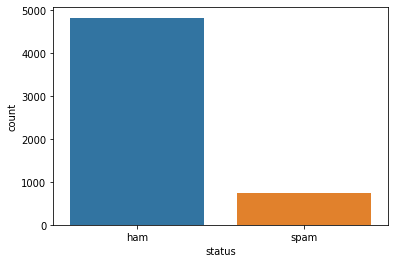

In [12]:
sns.countplot(df['status'])

importing libraries

In [13]:
from nltk.stem.porter import PorterStemmer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

tokenising the news data and zero padding to the fixed size 

In [16]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['message'].values)
sequences = tokenizer.texts_to_sequences(df['message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 8920 unique tokens.


verifying th tokenised output and zero padding 

In [17]:
print(len(sequences))
print(len(sequences[0]))
print(len(X))
print(len(X[0]))

5572
20
5572
130


label Encoding the output column

In [21]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
labels= label_encoder.fit_transform(df['status'])

In [22]:
labels

array([0, 0, 1, ..., 0, 0, 0])

creating the output column to 5 dimesional vector

In [35]:
labels = to_categorical(labels, num_classes=2)

In [36]:
labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

splitting data to train and test for proper evaluaton

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

verifying the split

In [38]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((4179, 130), (4179, 2), (1393, 130), (1393, 2))


defining the training paramters

In [46]:
epochs = 50
emb_dim = 100
batch_size = 64

creating the model

In [49]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(2, activation='softmax'))

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 130, 100)          800000    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 130, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 842,370
Trainable params: 842,370
Non-trainable params: 0
_________________________________________________________________
None


training the model

In [52]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.01)])

Epoch 1/50
53/53 [==============================] - 16s 296ms/step - loss: 0.1454 - acc: 0.9569 - val_loss: 0.0842 - val_acc: 0.9797
Epoch 2/50
53/53 [==============================] - 16s 308ms/step - loss: 0.0758 - acc: 0.9776 - val_loss: 0.0540 - val_acc: 0.9856
Epoch 3/50
53/53 [==============================] - 15s 284ms/step - loss: 0.0514 - acc: 0.9829 - val_loss: 0.0592 - val_acc: 0.9844
Epoch 4/50
53/53 [==============================] - 15s 285ms/step - loss: 0.0402 - acc: 0.9883 - val_loss: 0.0430 - val_acc: 0.9856
Epoch 5/50
53/53 [==============================] - 15s 285ms/step - loss: 0.0300 - acc: 0.9919 - val_loss: 0.0527 - val_acc: 0.9868
Epoch 6/50
53/53 [==============================] - 15s 287ms/step - loss: 0.0227 - acc: 0.9949 - val_loss: 0.0611 - val_acc: 0.9856
Epoch 7/50
53/53 [==============================] - 15s 286ms/step - loss: 0.0139 - acc: 0.9952 - val_loss: 0.0446 - val_acc: 0.9892
Epoch 8/50
53/53 [==============================] - 15s 286ms/step - 

evaluating the model on test data

In [59]:
accr = model.evaluate(X_test,y_test)
print('loss and accuracy on the test data are {},{}'.format(round(accr[0],2),round(accr[1],2)))

44/44 [==============================] - 2s 45ms/step - loss: 0.0743 - acc: 0.9835
loss and accuracy on the test data are 0.07,0.98


In [60]:
pred = model.predict(X_test)

44/44 [==============================] - 2s 28ms/step


converting the output data back to one dimension

In [61]:
pred_cat = np.argmax(pred, axis=-1)
test_cat = np.argmax(y_test, axis=-1)

Comparing the visualisation of both of the test and train data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


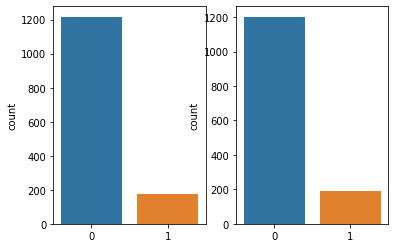

In [62]:
plt.subplot(1,2,1)
sns.countplot(pred_cat)
plt.subplot(1,2,2)
sns.countplot(test_cat)

#model using Word2vec

importing trained word2vec

In [63]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


finding the output dimension of the vector

In [66]:
glove_gensim['text'].shape

(100,)

creating a numpy array containing all the the vectors curresponding to token

In [67]:
vector_size = 100
total_words = 8000
gensim_weight_matrix = np.zeros((total_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < total_words: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


verifying the vector array 

In [69]:
gensim_weight_matrix.shape

(8000, 100)

creating the model and passing vector array of token words

In [84]:
model2 = Sequential()
model2.add(Embedding(n_most_common_words, vector_size, input_length=X.shape[1],weights = [gensim_weight_matrix],trainable = False))
model2.add(SpatialDropout1D(0.7))
model2.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model2.add(Dense(2, activation='softmax'))

In [85]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 130, 100)          800000    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 130, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 842,370
Trainable params: 842,370
Non-trainable params: 0
_________________________________________________________________
None


training the model

In [86]:
history = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.01)])

Epoch 1/50
53/53 [==============================] - 18s 282ms/step - loss: 0.4473 - acc: 0.8166 - val_loss: 0.5120 - val_acc: 0.8660
Epoch 2/50
53/53 [==============================] - 13s 249ms/step - loss: 0.2843 - acc: 0.8842 - val_loss: 0.5188 - val_acc: 0.8696
Epoch 3/50
53/53 [==============================] - 18s 338ms/step - loss: 0.2184 - acc: 0.9109 - val_loss: 0.5191 - val_acc: 0.8732
Epoch 4/50
53/53 [==============================] - 19s 356ms/step - loss: 0.1995 - acc: 0.9180 - val_loss: 0.2357 - val_acc: 0.9342
Epoch 5/50
53/53 [==============================] - 18s 343ms/step - loss: 0.1867 - acc: 0.9309 - val_loss: 0.2029 - val_acc: 0.9402
Epoch 6/50
53/53 [==============================] - 13s 249ms/step - loss: 0.1795 - acc: 0.9297 - val_loss: 0.1868 - val_acc: 0.9438
Epoch 7/50
53/53 [==============================] - 13s 248ms/step - loss: 0.1880 - acc: 0.9291 - val_loss: 0.2087 - val_acc: 0.9378
Epoch 8/50
53/53 [==============================] - 13s 248ms/step - 

finding the accuracy of the model

In [88]:
accr = model2.evaluate(X_test,y_test)
print('loss and accuracy on the test data are {},{}'.format(round(accr[0],2),round(accr[1],2)))

44/44 [==============================] - 1s 28ms/step - loss: 0.1149 - acc: 0.9634
loss and accuracy on the test data are 0.11,0.96


In [89]:
pred = model2.predict(X_test)

44/44 [==============================] - 2s 30ms/step


In [90]:
pred_cat = np.argmax(pred, axis=-1)
test_cat = np.argmax(y_test, axis=-1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


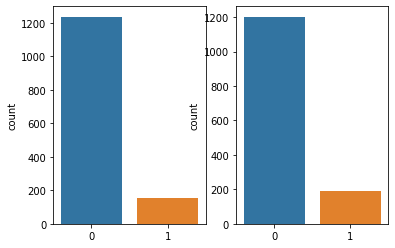

In [91]:
plt.subplot(1,2,1)
sns.countplot(pred_cat)
plt.subplot(1,2,2)
sns.countplot(test_cat)

since data is imbalanced , finding the confusion matrix

In [92]:
from sklearn import metrics

In [94]:
print(metrics.classification_report(pred_cat, test_cat))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1237
           1       0.77      0.95      0.85       156

    accuracy                           0.96      1393
   macro avg       0.88      0.96      0.92      1393
weighted avg       0.97      0.96      0.96      1393

